# Import Libraries

In [96]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV

import xgboost

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [112]:
## Recursive Feature Elimination with Cross-Validation
def rfecv(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=KFold(cv, 
                           shuffle=True, 
                           random_state=42),
                  scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return rfecv

## Plotting % of Correct Classification
def plot_pcc(rfecv, title):
    
    plt.figure(figsize=(10, 9))
    plt.title(title, 
              fontsize=18, 
              fontweight='bold', 
              pad=20)
    plt.xlabel('Number of features selected', 
               fontsize=14, 
               labelpad=20)
    plt.ylabel('% Correct Classification', 
               fontsize=14, 
               labelpad=20)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             color='#303F9F', 
             linewidth=3)
    
    plt.show()

## Plotting feature importances
def feature_importance(rfecv, X, title): 
        
    df = pd.DataFrame()
    
    df['column'] = X.columns
    df['importance'] = rfecv.estimator_.feature_importances_
    
    df.sort_values(by='importance', 
                   ascending=False, 
                   inplace=True, 
                   ignore_index=True)
    
    sns.set(rc = {'figure.figsize':(8,10)})
    ax = sns.barplot(y='column', 
                     x='importance',
                     data=df,
                     palette='viridis')
    
    ax.set_title(title, 
                 fontsize=18)

## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    y_pred = model.predict(scaled_df)

    return y_pred

## Evaluate the final model
def eval_model(y, y_pred, title):
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r_squared = r2_score(y, y_pred)

    print(f'{title}')
    print(f'Mean Squared Error: {np.round(mse, 2)}')
    print(f'Root Mean Squared Error: {np.round(rmse, 2)}')
    print(f'Mean Absolute Error: {np.round(mae, 2)}')
    print(f'R-squared Error: {np.round(r_squared, 2)}')

## Plotting Learning curves
def plot_learing_curve(model, X, y, cv, model_title):

    train_sizes = [50, 100, 200, 400, 760]

    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, 
                                                                  train_sizes=train_sizes, 
                                                                  cv=cv, 
                                                                  scoring='neg_mean_squared_error', 
                                                                  shuffle=True)

    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    plt.style.use('seaborn')
    plt.plot(train_sizes, 
             train_scores_mean, 
             label = 'Training error')
    plt.plot(train_sizes, 
             validation_scores_mean, 
             label = 'Validation error')
    plt.ylabel('MSE', 
               fontsize = 14)
    plt.xlabel('Training set size', 
               fontsize = 14)
    plt.title(f'Learning curves for a {model_title} model', 
              fontsize = 18, 
              y = 1.03)
    plt.legend()
    plt.ylim(0,40)

# Load Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [4]:
str_sed_data = pd.read_csv(data_path + '/Kodangal_gcM.csv')

In [5]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,u,pt,pd,toposheet,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,14.668,...,1.811020,0,0,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,14.042,...,2.203597,0,0,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910,...,2.711943,0,0,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430,...,2.982200,0,0,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990,...,3.249200,0,0,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0


# EDA

In [6]:
rem_elem = []
for col in str_sed_data.columns:
    if (str_sed_data[col] == 0).all():
        rem_elem.append(col)
print(f"Elements which don't contribute in the sediment composition: {rem_elem}")

Elements which don't contribute in the sediment composition: ['loi', 'pt', 'pd']


In [7]:
str_sed_data.drop(rem_elem, axis=1, inplace=True)

In [8]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,ta,w,u,toposheet,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,14.668,...,0.862203,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,14.042,...,0.958655,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910,...,1.428838,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430,...,1.542800,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990,...,1.467300,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [9]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

In [10]:
len(str_elem)

62

In [11]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,44.750,9.414,3.312,0.543,14.668,1.573,0.073,0.152,1.258,0.129,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,45.129,9.853,3.748,0.580,14.042,1.480,0.109,0.167,1.207,0.080,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,58.283,12.534,7.768,1.321,2.910,1.912,0.192,0.050,0.800,0.061,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,61.180,11.670,8.340,1.420,2.430,1.710,0.180,0.250,0.660,0.080,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,60.300,11.470,8.270,1.430,1.990,1.610,0.170,0.230,0.580,0.060,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


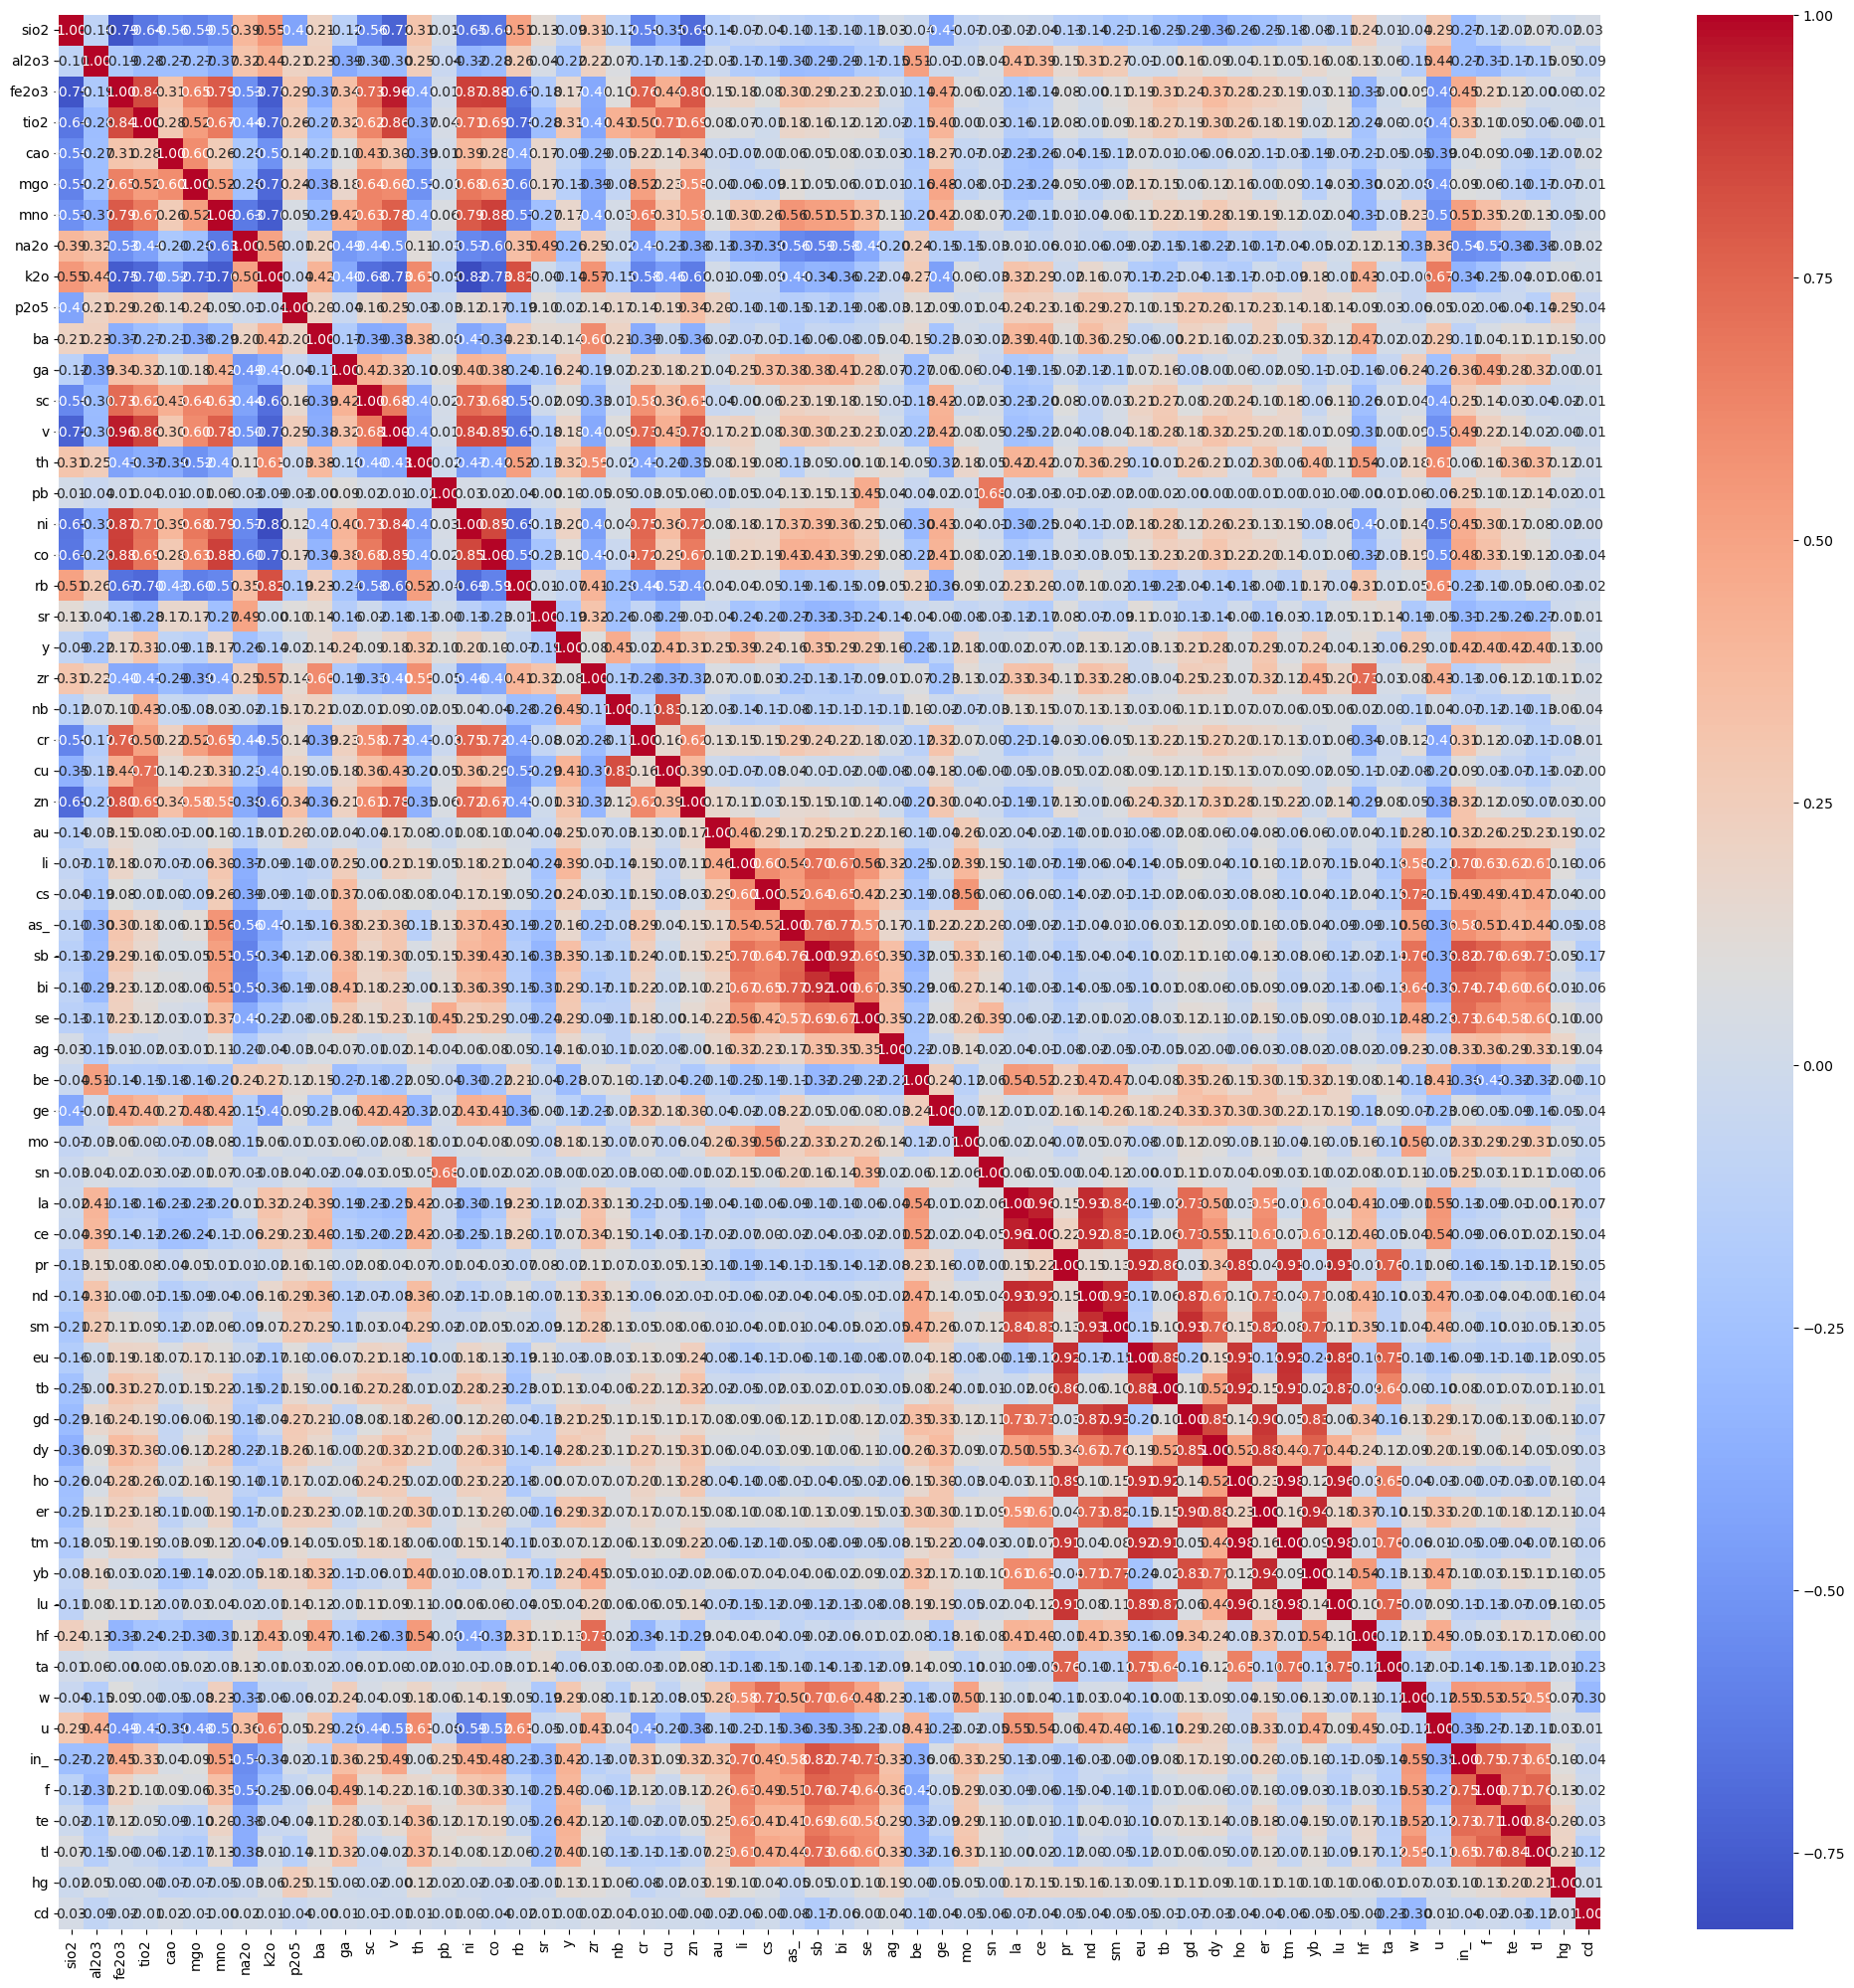

In [12]:
plt.figure(figsize=(25,25))
sns.heatmap(elem_df.corr(), 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

### Histogram plots

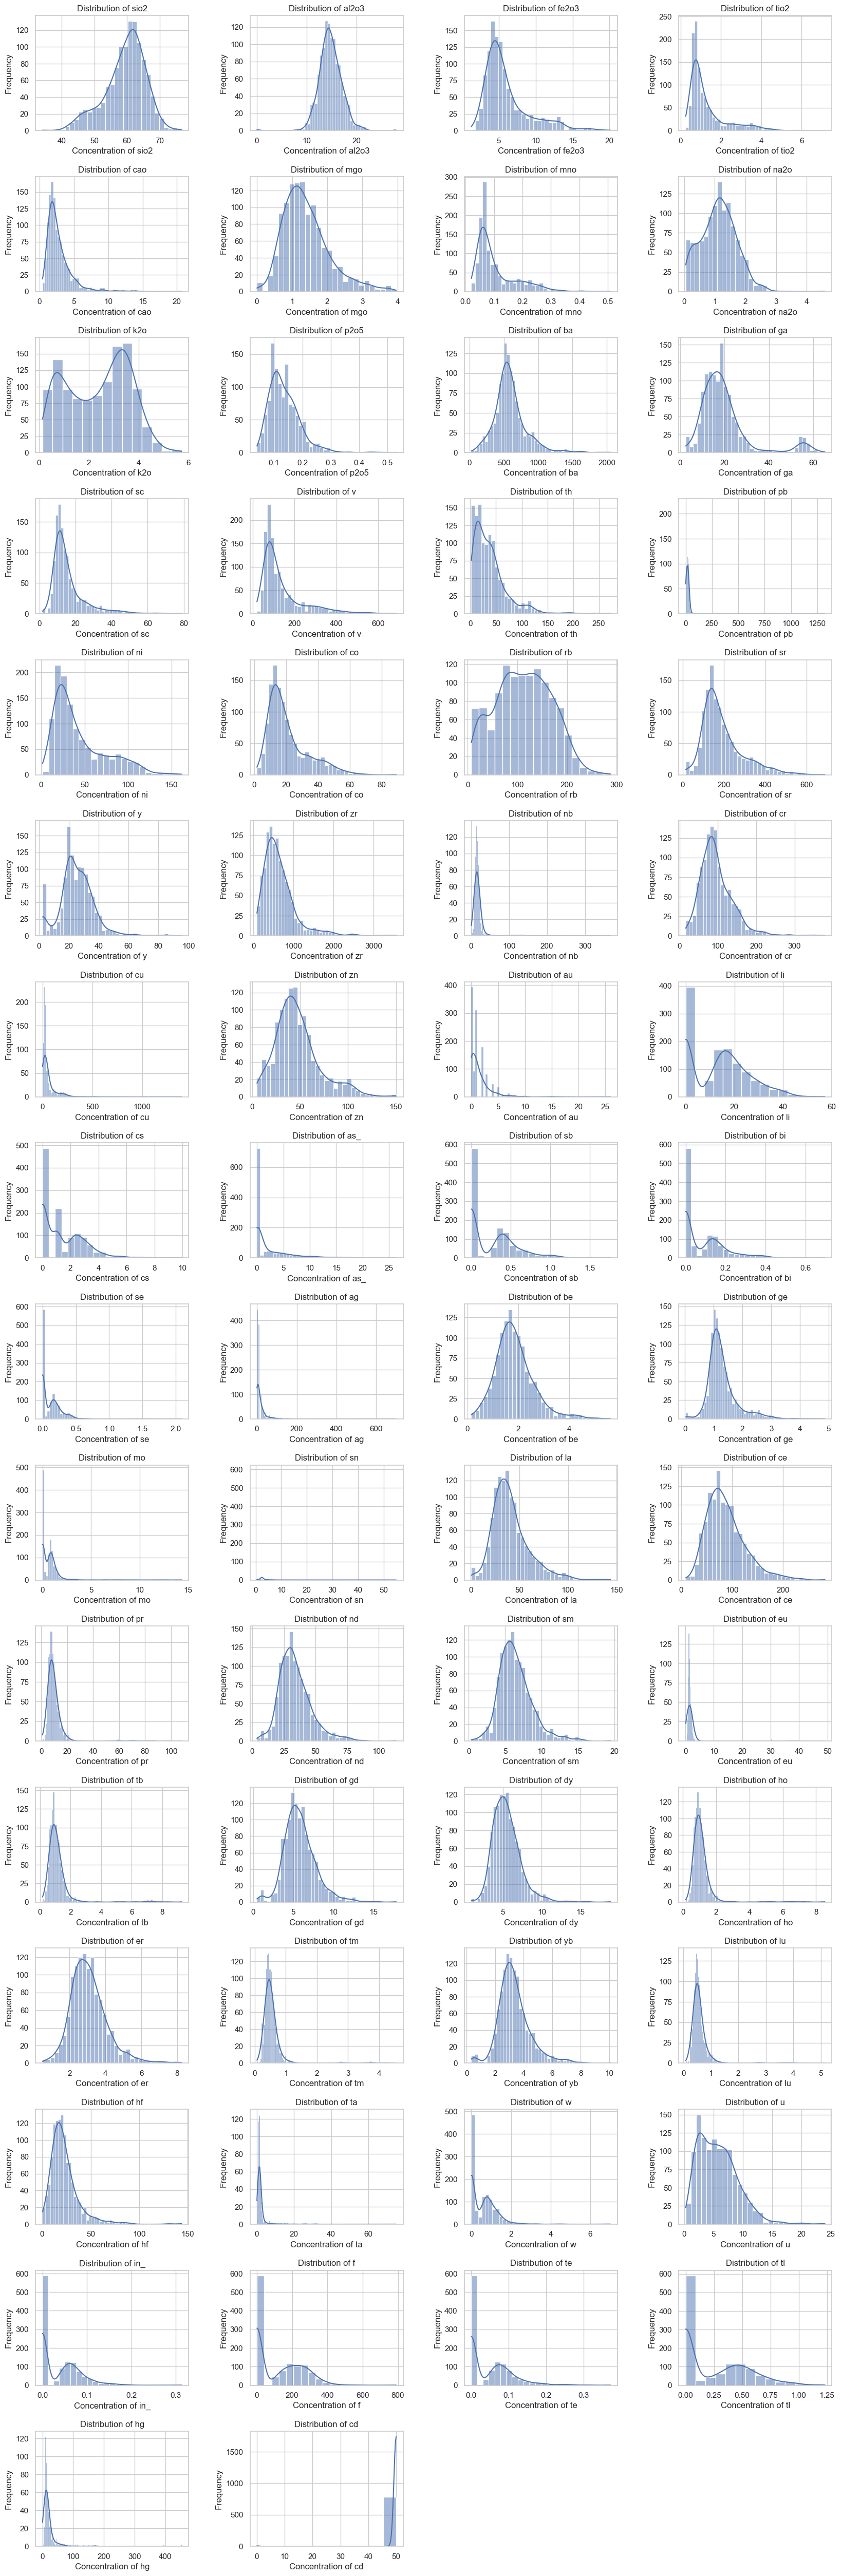

In [13]:
num_elem = len(str_elem)
num_cols = 4
num_rows = (num_elem + num_cols - 1)//num_cols 

sns.set(style='whitegrid')

fig, axes = plt.subplots(num_rows, 
                         num_cols, 
                         figsize=(num_cols*5, num_rows*4))

fig.subplots_adjust(hspace=0.4, 
                    wspace=0.4)

for i, elem in enumerate(str_elem):

    ax = axes[i // num_cols, i % num_cols]  # Determine the position in the grid
    sns.histplot(elem_df[elem], 
                 kde=True, 
                 ax=ax)
    ax.set_title(f'Distribution of {elem}')
    ax.set_xlabel(f'Concentration of {elem}')
    ax.set_ylabel('Frequency')

# If there are any empty subplots in the grid, hide them
for j in range(i + 1, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.show()

## Boxplots

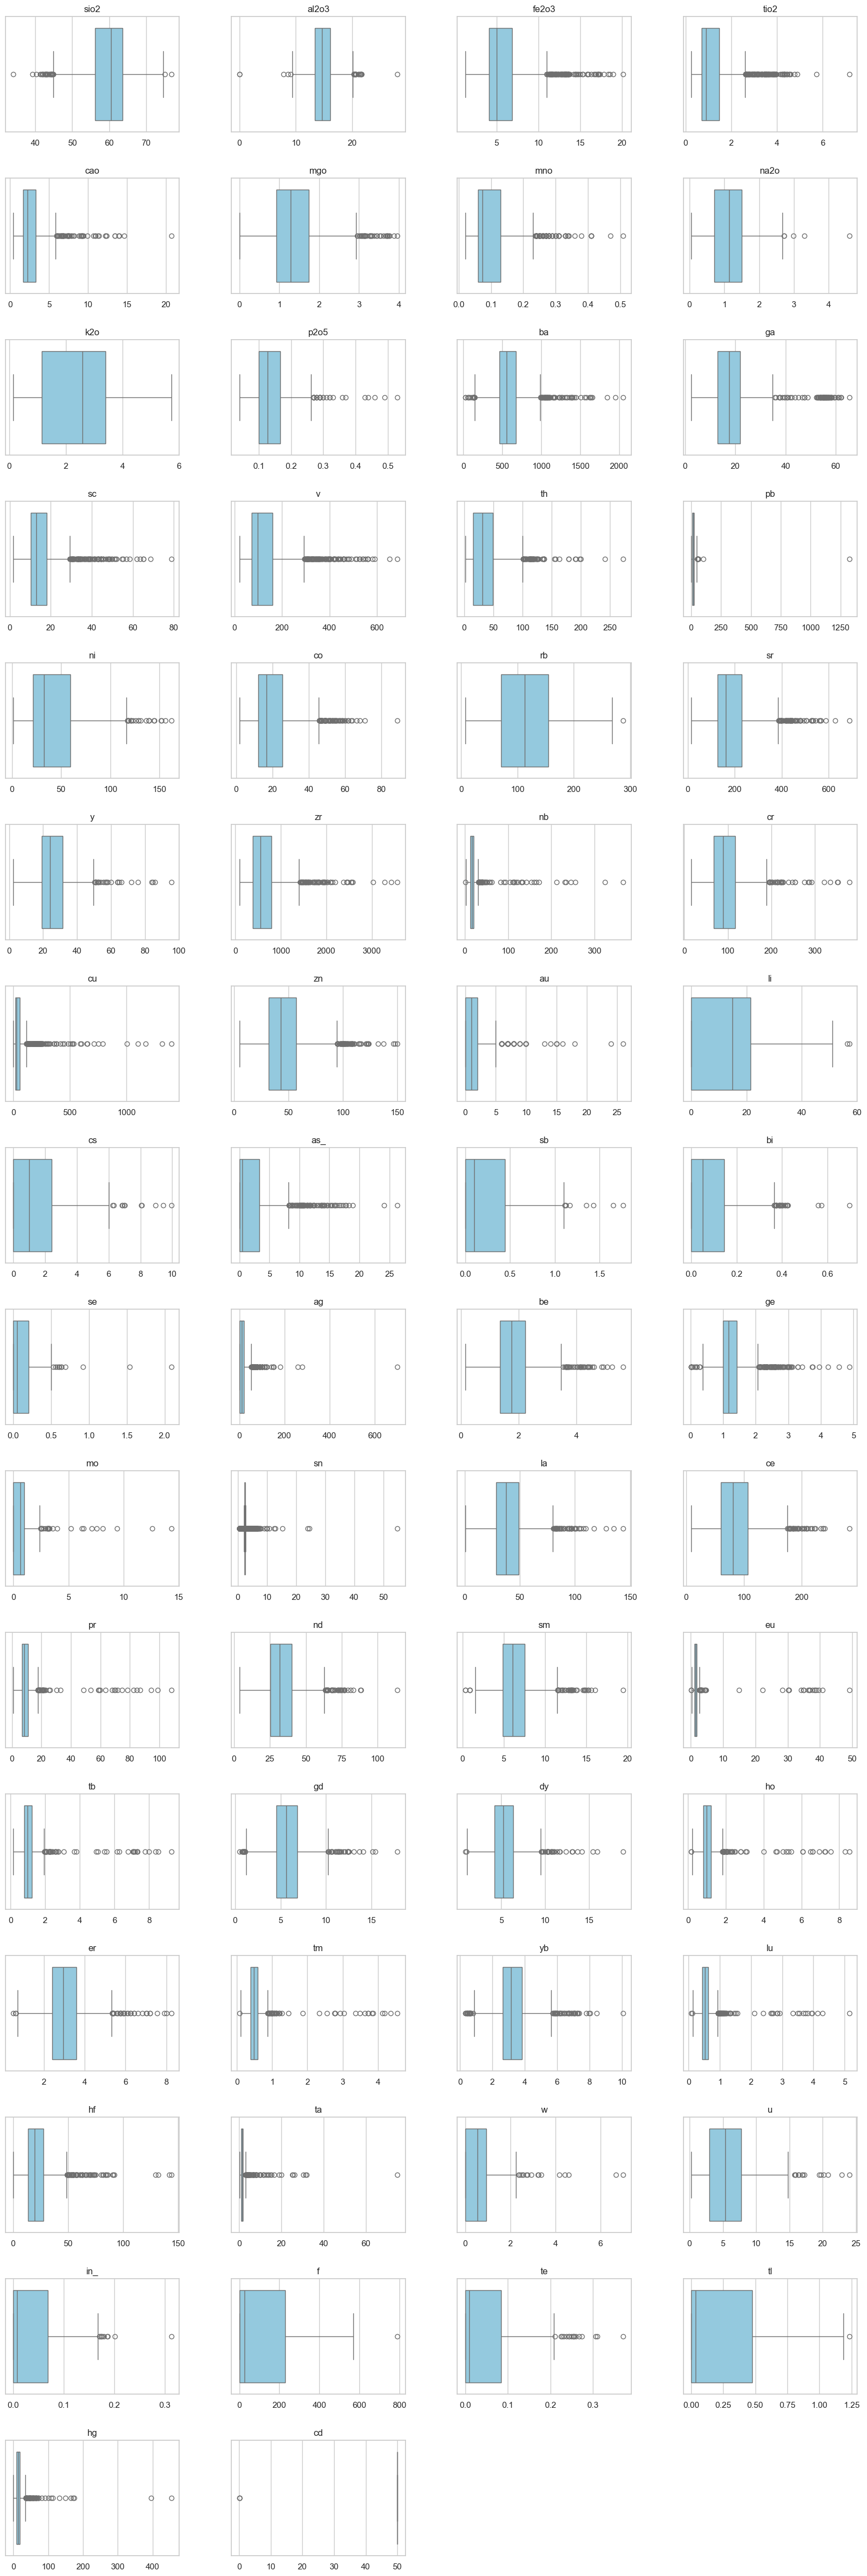

In [14]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_df[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

### Drop elements based on certain condition

- Elements having concentration values less than 1

In [12]:
drop_elem = ['mno', 'p2o5', 'sb', 'bi', 'se', 'in_', 'te', 'tl']

In [13]:
elem_df.drop(drop_elem, axis=1, inplace=True)

- Elements having same almost same values at each sample

In [14]:
elem_df.drop(['cd'], axis=1, inplace=True)

## Handling outliers

In [15]:
def handle_outl(df):

    cols = list(df.columns)
    
    for elem in cols:
        
        Q1 = df[elem].quantile(0.25)
        Q3 = df[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        quantiles = {
            87 : df[elem].quantile(0.87), 
            90 : df[elem].quantile(0.90),
            92.5 : df[elem].quantile(0.925),
            95 : df[elem].quantile(0.95),
            97.5 : df[elem].quantile(0.975),
            99 : df[elem].quantile(0.99)
        }
        
        min_diff = float('inf')
        nearest_key = None
        for key, val in quantiles.items():
        
            if val >= upr_bnd:
                diff = val - upr_bnd
                if diff < min_diff:
                    min_diff = diff
                    nearest_key = key
        
        if nearest_key is None:
            df[elem] = df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)
            continue
        
        nearest_key = (100 - nearest_key) / 100
        nearest_key = np.round(nearest_key, 3)
        df[elem] = winsorize(df[elem], limits=(0.05, nearest_key))

    return df

In [16]:
elem_outl_df = handle_outl(elem_df)

### After handling outliers

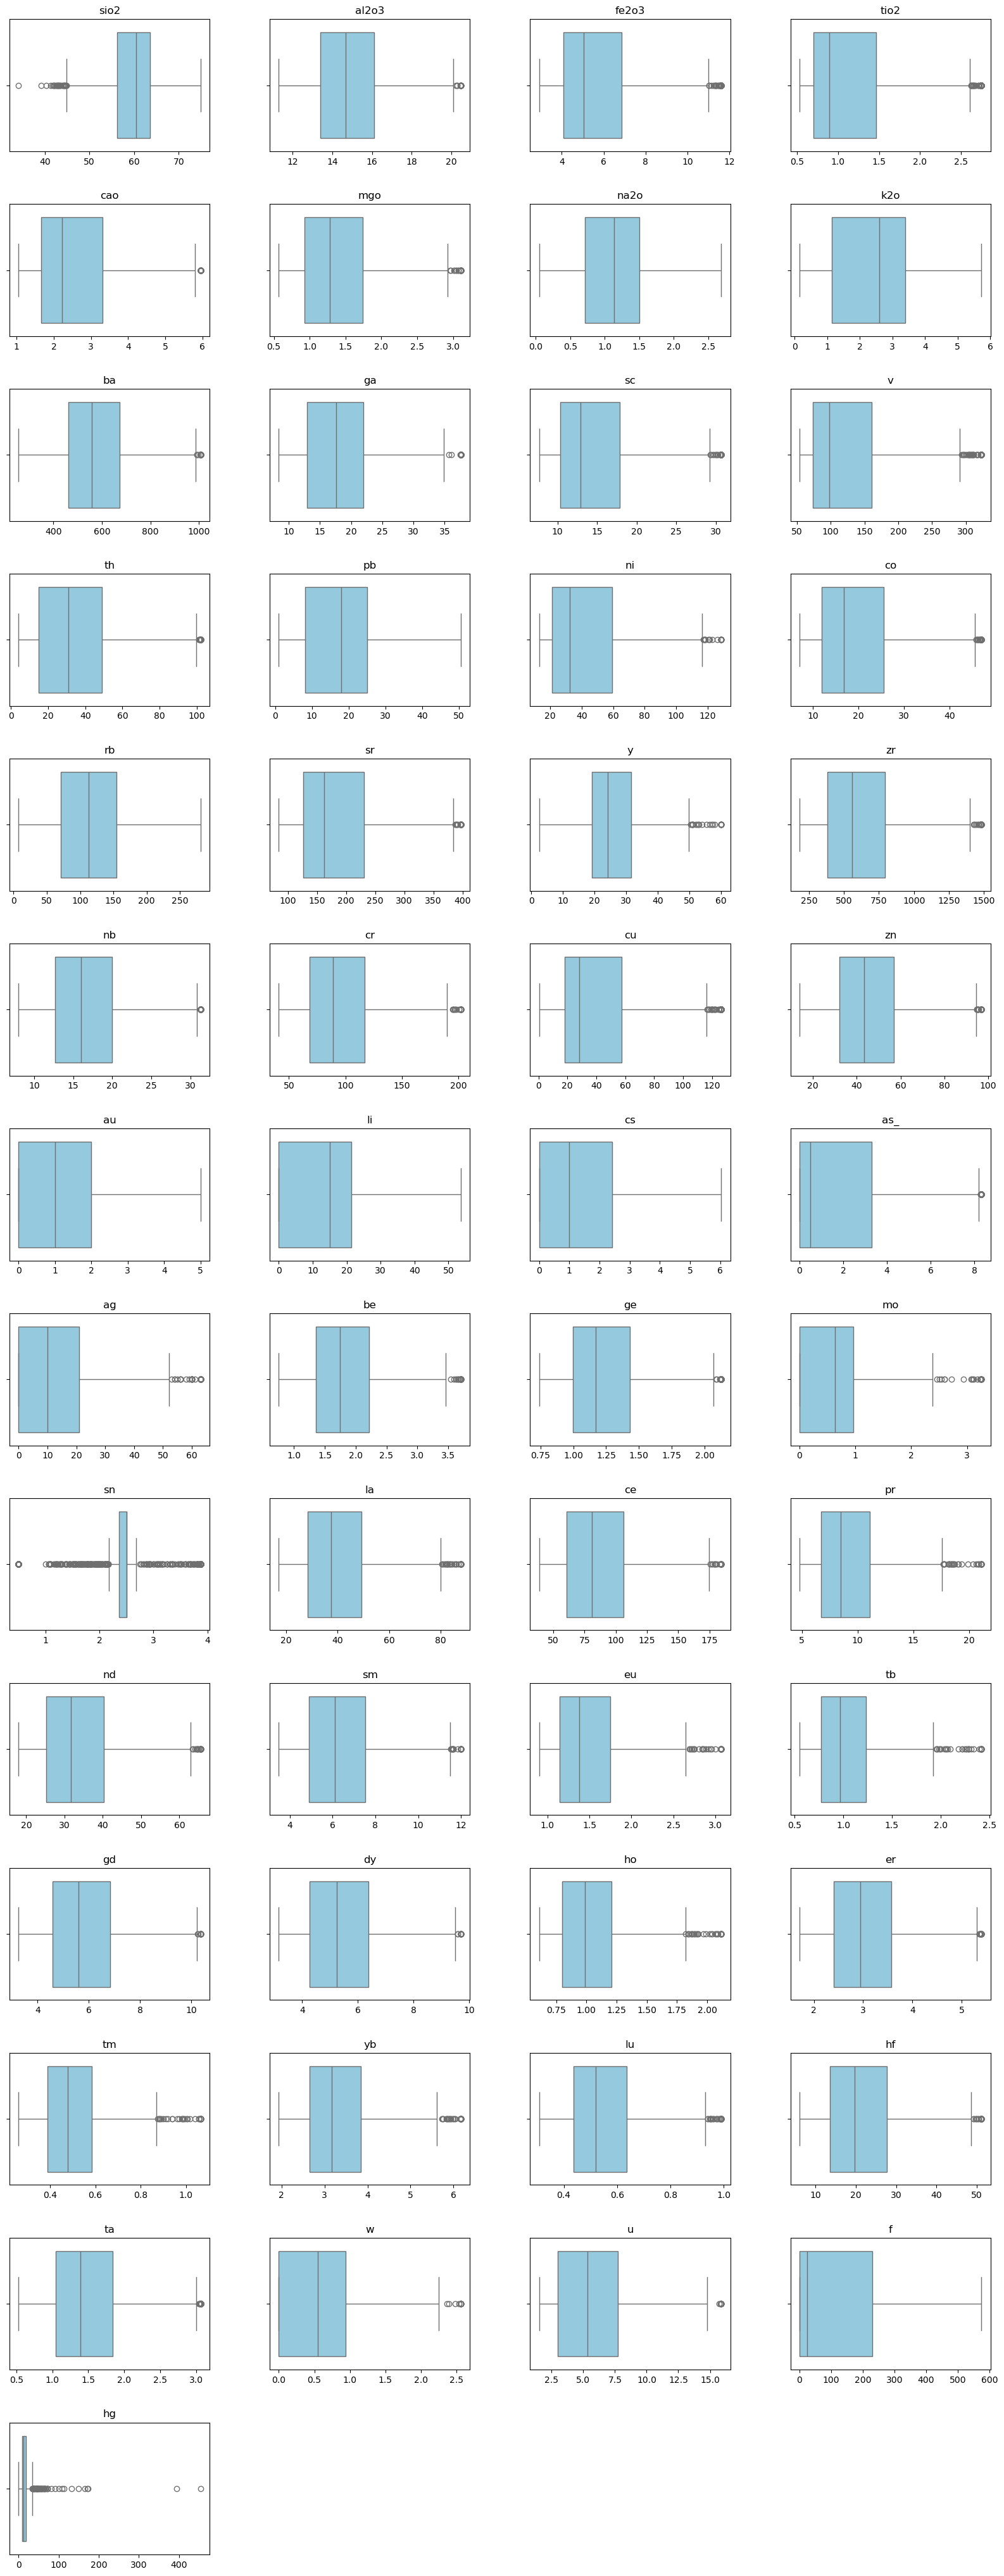

In [17]:
n_elem = len(elem_outl_df.columns)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(elem_outl_df.columns, axes.flatten())):
    sns.boxplot(x=elem_outl_df[elem_outl_df.columns][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# Feature Selection

## Split into train, validation and test data

In [18]:
(elem_df.isna()).any()

sio2     False
al2o3    False
fe2o3    False
tio2     False
cao      False
mgo      False
na2o     False
k2o      False
ba       False
ga       False
sc       False
v        False
th       False
pb       False
ni       False
co       False
rb       False
sr       False
y        False
zr       False
nb       False
cr       False
cu       False
zn       False
au       False
li       False
cs       False
as_      False
ag       False
be       False
ge       False
mo       False
sn       False
la       False
ce       False
pr       False
nd       False
sm       False
eu       False
tb       False
gd       False
dy       False
ho       False
er       False
tm       False
yb       False
lu       False
hf       False
ta       False
w        False
u        False
f        False
hg        True
dtype: bool

In [19]:
elem_df['hg'] = elem_df['hg'].fillna(0)

In [20]:
train_df = elem_df.copy()
target = elem_df['au']
train_df.drop(['au'], axis=1, inplace=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

## Normalize

In [23]:
sc = StandardScaler()

norm_data = sc.fit_transform(X_train)

X_train_norm = pd.DataFrame(norm_data, 
                            index=X_train.index, 
                            columns=X_train.columns)

## Estimator: Random Forest

In [27]:
rf = RandomForestRegressor(n_jobs=-1)
rfecv_rf = rfecv(rf, X_train_norm, y_train, 1, 5)

In [28]:
print('Optimal number of features: {}'.format(rfecv_rf.n_features_))

Optimal number of features: 36


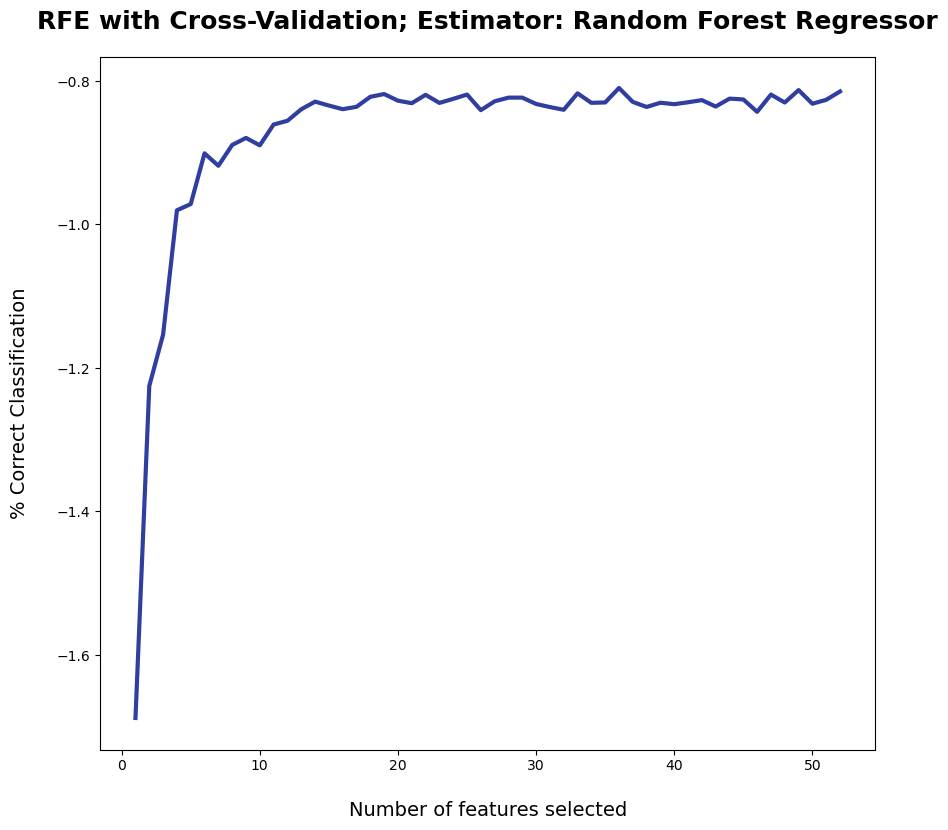

In [29]:
plot_pcc(rfecv_rf, 'RFE with Cross-Validation; Estimator: Random Forest Regressor')

In [30]:
X_rf = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_rf.support_ == False)[0]], axis=1)

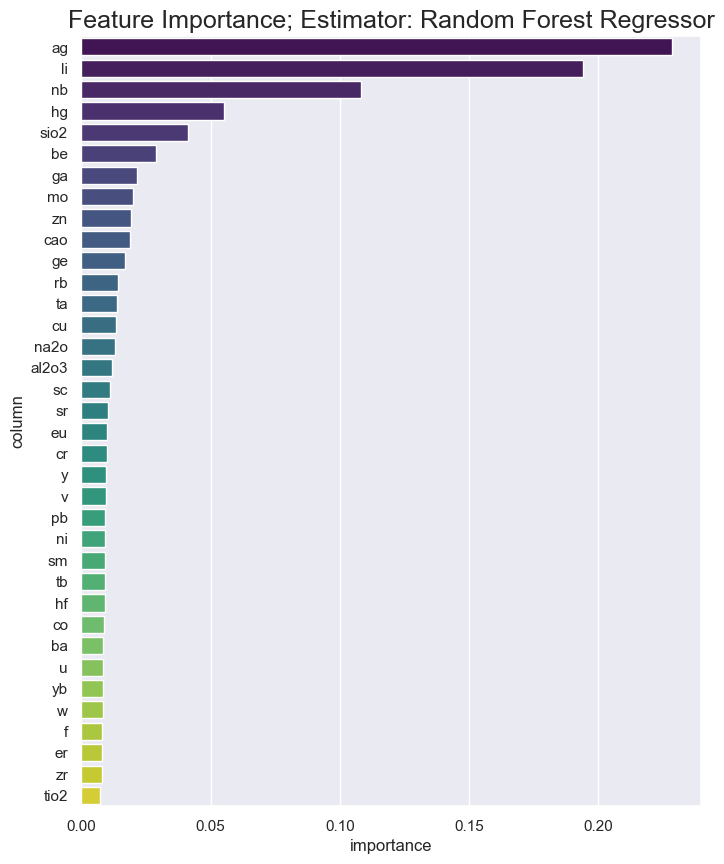

In [31]:
feature_importance(rfecv_rf, X_rf, 'Feature Importance; Estimator: Random Forest Regressor')

In [32]:
X_rf = X_rf[['li', 'ag', 'nb', 'sio2', 'hg', 'be']]

## Estimator: Gradient Boosting

In [75]:
gbr = GradientBoostingRegressor()
rfecv_bgr = rfecv(gbr, X_train_norm, y_train, 1, 5)

In [76]:
print('Optimal number of features: {}'.format(rfecv_bgr.n_features_))

Optimal number of features: 32


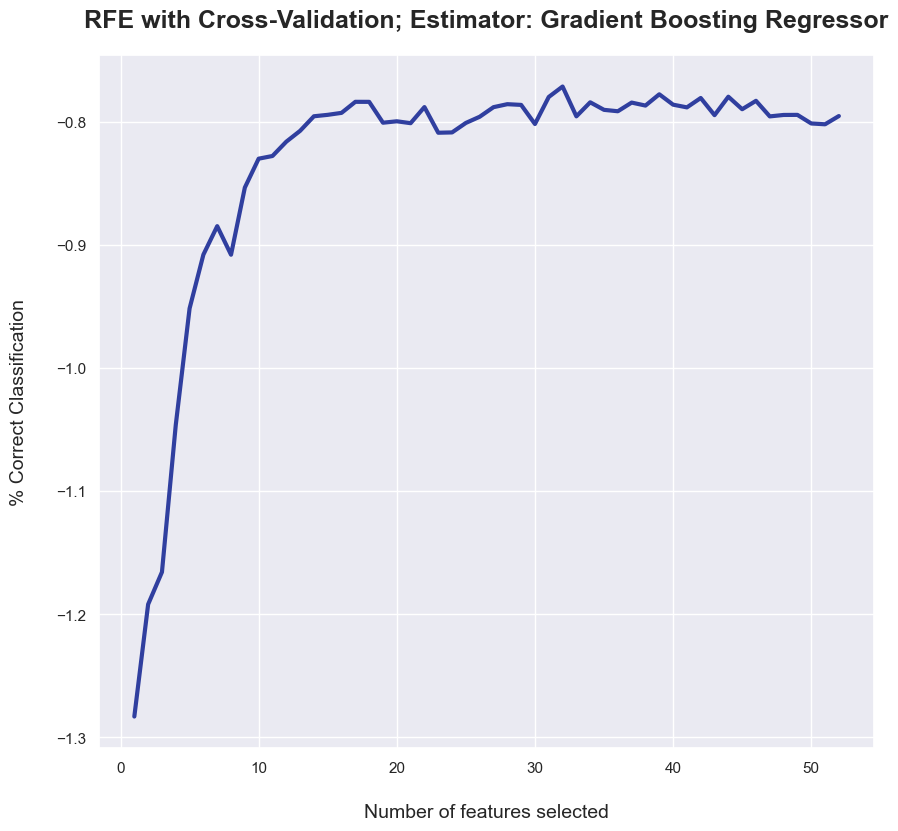

In [77]:
plot_pcc(rfecv_bgr, 'RFE with Cross-Validation; Estimator: Gradient Boosting Regressor')

In [78]:
X_gbr = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_bgr.support_ == False)[0]], axis=1)

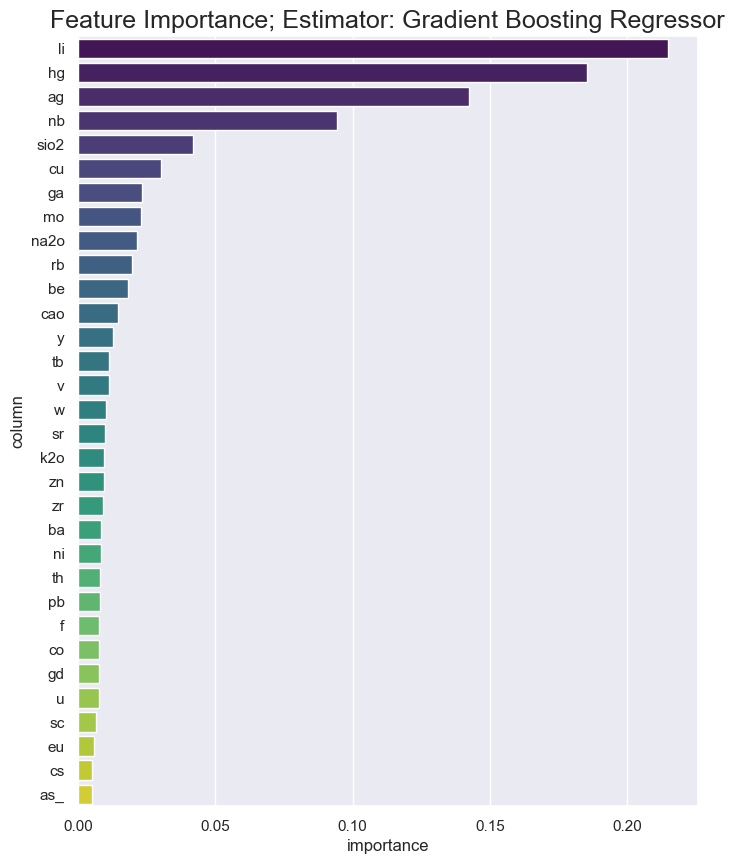

In [79]:
feature_importance(rfecv_bgr, X_gbr, 'Feature Importance; Estimator: Gradient Boosting Regressor')

In [80]:
X_gbr = X_gbr[['li', 'ag', 'hg', 'nb', 'sio2', 'cu']]

# Model Training

## Random Forest

- Estimator: Random Forest

In [98]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_rf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}


### Run the models on validation data

In [99]:
y_pred_val = pred_val(X_val, list(X_rf.columns), sc, grid_search)

In [100]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 0.96
Root Mean Squared Error: 0.98
Mean Absolute Error: 0.56
R-squared Error: 0.61


### Run the model on test data

In [101]:
y_pred = pred_val(X_test, list(X_rf.columns), sc, grid_search)

In [102]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 1.01
Root Mean Squared Error: 1.0
Mean Absolute Error: 0.66
R-squared Error: 0.53


### Learning Curve

In [ ]:
plot_learing_curve(grid_search, X_rf, y_train, 5, 'Random Forest')

- Estimator: Gradient Boosting

In [81]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_gbr, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 50}


### Run the models on validation data

In [82]:
y_pred_val = pred_val(X_val, list(X_gbr.columns), sc, grid_search)

In [83]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 1.04
Root Mean Squared Error: 1.02
Mean Absolute Error: 0.61
R-squared Error: 0.57


### Run the model on test data

In [84]:
y_pred = pred_val(X_test, list(X_gbr.columns), sc, grid_search)

In [85]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 0.95
Root Mean Squared Error: 0.98
Mean Absolute Error: 0.64
R-squared Error: 0.56


## XGBoost

- Estimator: Random Forest

In [70]:
param_grid = {
    'n_estimators': [200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    'reg_alpha': [0.5, 1],       
    'reg_lambda': [0.5, 1],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search = GridSearchCV(xgb, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_rf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'reg_alpha': 1, 'reg_lambda': 1}


### Run the model on validation data

In [71]:
y_pred_val = pred_val(X_val, list(X_rf.columns), sc, grid_search)

In [72]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 0.95
Root Mean Squared Error: 0.97
Mean Absolute Error: 0.58
R-squared Error: 0.61


### Run the model on test data

In [73]:
y_pred = pred_val(X_test, list(X_rf.columns), sc, grid_search)

In [74]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 0.98
Root Mean Squared Error: 0.99
Mean Absolute Error: 0.67
R-squared Error: 0.54


- Estimator: Gradient Boosting

In [91]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    'reg_alpha': [0, 0.1, 0.5, 1],       
    'reg_lambda': [0.5, 1, 1.5, 2],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search = GridSearchCV(xgb, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_gbr, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 2}


### Run the model on validation data

In [92]:
y_pred_val = pred_val(X_val, list(X_gbr.columns), sc, grid_search)

In [93]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 1.12
Root Mean Squared Error: 1.06
Mean Absolute Error: 0.67
R-squared Error: 0.54


### Run the model on test data

In [94]:
y_pred = pred_val(X_test, list(X_gbr.columns), sc, grid_search)

In [95]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 0.98
Root Mean Squared Error: 0.99
Mean Absolute Error: 0.68
R-squared Error: 0.54
